## Introduction

This project is about creating a convolutional neural network to recognize images of the playing card game [fantastische reiche](https://www.spiel-des-jahres.de/spiele/fantastische-reiche/). If you have never heard of it - give it a try. Especially if you like deck-building games, this one will be a lot of fun. So why do i want to detect cards? Well, at the end of the game you have to count points based on the cards in your hand. This maybe does not sound too difficult, but the cards all influence each other! E.g. "Flash" counts much more while you also have "Thunderstorm". Your "Elven Archers" improve when you have *no* weather-type card and your mighty "magic wand" is obviously useless if you don't have at least a single wizard. You see things can get pretty complicated. Luckly the creators of the game provide you with an official [score calculator](https://fantastische-reiche.de/). This works great - but you have to select each card you have individualy from a list of all playing cards. Wouldn't it be awesome if we could make this process just a little bit simpler? 

## Aim
I would like to write an app in the near future which allows to detect the cards in your hand and calculate the final score. I imagine it to work like a QR-Code scanner, where you just point at your cards one after another to add them to the calculations. No pushing of the "shutter"-button of the camera required. 
This project will be one part of the final goal. I want to train a small, easy to understand yet accurate model which can be used locally on a phone. Altough this was not part of the lecture, i also wrote a (very basic!) android application out of curiousity to see how i can use my model trained in keras in "real-life"-applications. (Hopefully you can share the excitement i felt when it worked for the first time and i was able to detect cards using my phone. So cool)

## About the Code
I do not like to have a lot of inline-comments. I will give you some insight in my reasoning and the development process between the cells. Enjoy!

> “Simplicity is the final achievement. \
> After one has played a vast quantity of notes and more notes, it is simplicity that emerges as the crowning reward of art.” 

In [168]:
import numpy as np
import tensorflow as tf

from tensorflow import keras
from keras import layers
from keras.models import Sequential
from keras.layers import Input

# required for confusion matrix and heatmap
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

As you can imagine optaining the data was a big part of the project, since no dataset is availbile. There are 53 different playing cards, and i wanted to have at least 50 (better 100) images for each card. I spend a couple of hours taking photos and optimizing the camera app on my smartphone so the processing wouldn't take as long and i can shoot photos faster. Have you ever had your phone crash because you took too many photos in succession? Well, i certanly haven't before this project. After my phone froze for the third time i sat on my bad at 2am and thought there had to be a better way to do this. And i had an idea! What if instead of taking photos, i would do videos of the cards, showing them from different angles? I ended up doing roughly 30 seconds video of each card, and then extracted the individual frames using the command line tool [ffmpeg](https://www.ffmpeg.org/). With this, i had ~25.000 images as training / validation data within half an hour.

In [5]:
dataPathLocal = "G:/My Drive/keras_project/dataDigits"

I tested multiple different resolutions for the image. Some square, some rectangle. I thought since the cards are not square a narrower image would highlight more important features of the card. To my surprise this was not really the case. This (pretty small) resolution of 64x64 pixels showed no worse performance than other resolutions like 128x128 or 320x180 which i tried - while being significantly faster to train. I can imagine that larger resolutions would be relevant if the photo was taken from far away or the cards would be more "hidden" in the image. For my application, this is not the case.

In [7]:
batch_size = 32
num_classes = 53

img_height = 64
img_width = 64

In [9]:
train_ds, val_ds = keras.utils.image_dataset_from_directory(
    dataPathLocal,
    validation_split=0.2,
    subset="both",
    seed=42,
    image_size=(img_height, img_width),
     batch_size=batch_size
)

Found 25757 files belonging to 53 classes.
Using 20606 files for training.
Using 5151 files for validation.


Some caching that was recommended in the keras documentation

In [10]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

This model is very simililar to the one in the [documentation](https://www.tensorflow.org/tutorials/images/classification) of image classification on tensorflow. I tried mutliple (much more complicated) models, most showed good performance. I ended up with this is one, as it is simple, small and performs well. There is honestly not much to explain: I used rotation and zoom as data augmentation. The pixel-values are scaled from integers to floating points [0,255] -> (0,1). Three convolution layers with an increasing amount of filters and a constant kernel size of 3 to extract features and a final dense layer with 128 neurons. I used 'relu' as activation function for each layer. I thought about using 'softmax' for the dense layer, and while it also showed good results, the training was significantly slower. 'relu' worked fine out of the box so thats what i ended up with. Softmax is used on the networks output.

In [ ]:
model = Sequential([
    Input(shape=(img_height, img_width, 3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.Rescaling(1./255),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.2),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes, name="outputs")
])

I used the compile options recommended by Keras for this kind of problem. <code>SparseCategoricalCrossentropy</code> expects the labels as integer which was easier for me to do (using the folder names) than dealing with one-hot encoded labels using <code>CategoricalCrossentropy</code>.

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [11]:
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ random_rotation_1               │ (None, 64, 64, 3)      │             0 │
│ (RandomRotation)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_zoom_1 (RandomZoom)      │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_3 (Rescaling)         │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 64, 64, 16)     │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 32, 32, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 32, 32, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │       524,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ outputs (Dense)                 │ (None, 53)             │         6,837 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,664,513 (6.35 MB)

 Trainable params: 554,837 (2.12 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,109,676 (4.23 MB)

The network learned surprisingly fast. After three epochs (644 * 32 ~ 20k images each) the accuracy was already at around 80%! To be honest i expected this to be way more difficult, we have 53 different classes after all. I trained this network multiple times with an increasing amount of epochs. The last learning session was over the duration of 50 epochs and the highest validation accuracy i observed was 0.9996, or 99.96%. While this sounds amazing and i'm very happy with the result, i have to admit that the the training data is very similar. For each card the training data consists of one video, with my wooden desk as background and the same lighting conditions. I used this model in the android application i talked about in the introduction, and while it works great in most cases, its accuracy for real life use is not 99.96%. (maybe 85%). Taking the time to create more training data would certanly improve the (still awesome!) 85% effective accuracy even more.

In [ ]:
epochs=5
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

I used <code>SparseCategoricalCrossentropy</code> as loss-function. This means the labels are integer values (23, 44, 51 etc.). Since i am interested in the name of the card and not the integer value which i can not validate easily i created an array with all card names, and sorted them alphabetically. The training data in the integer-labled folders is also sorted alphabetically. So if the network outputs <code>13</code> as prediction, i just have to look up <code>card_names_sep[13]</code> to get the name of the card.

In [173]:
card_names = "kaiserin,koenig,koenigin,kriegsherr,prinzessin,elbenschuetzen,leichte_kavallerie,ritter,waldlaeufer,zwergeninfanterie,buch_der_veraenderung,juwel_der_ordnung,rune_des_schutzes,schild_von_keth,weltenbaum,basilisk,drache,einhorn,hydra,schlachtross,blitz,buschfeuer,feuerwesen,kerze,schmiede,grosse_flut,insel,quelle_des_lebens,sumpf,wasserwesen,erdwesen,gebirge,glockenturm,hoehle,wald,elbischer_bogen,kampfzeppelin,kriegsschiff,schwert_von_keth,zauberstab,blizzard,luftwesen,rauch,regensturm,wirbelsturm,hexenmeister,sammler,herr_der_bestien,totenbeschwoerer,magierin,doppelgaenger,gestaltenwandler,spiegelung"
card_names_sep = card_names.split(",")
card_names_sep.sort()

Let's see how the input images look like, and how well our model does classifying them. Here we show the first batch (32 images) of the validation data and the prediction results.

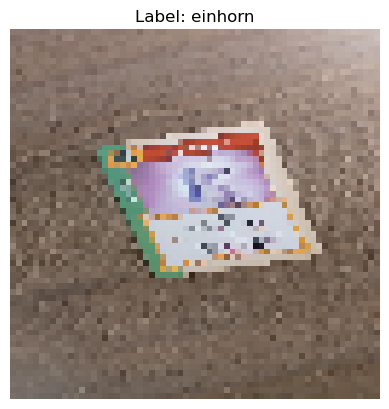

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
This image most likely belongs to einhorn with a 99.99 percent confidence.


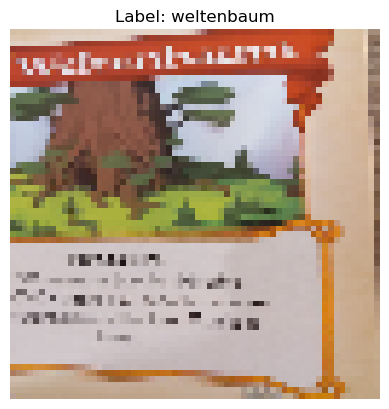

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
This image most likely belongs to weltenbaum with a 100.00 percent confidence.


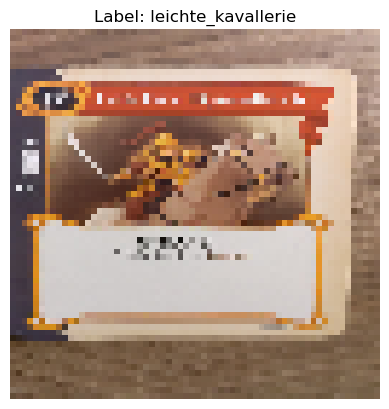

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
This image most likely belongs to leichte_kavallerie with a 100.00 percent confidence.


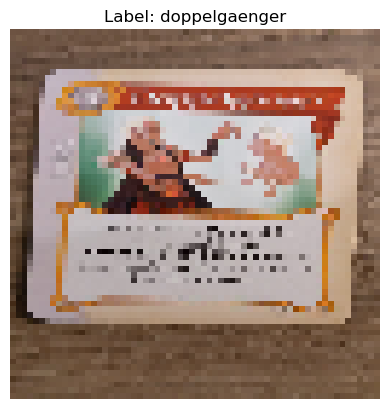

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
This image most likely belongs to doppelgaenger with a 100.00 percent confidence.


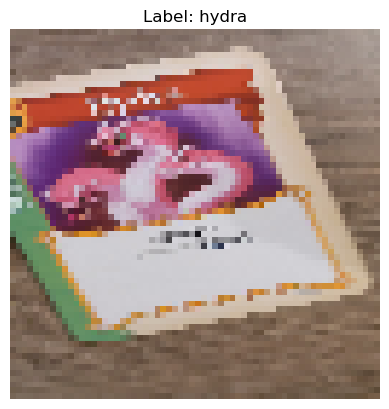

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
This image most likely belongs to hydra with a 100.00 percent confidence.


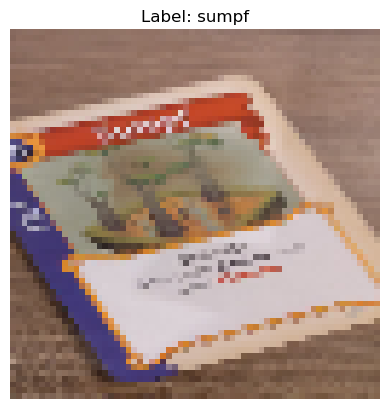

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
This image most likely belongs to sumpf with a 100.00 percent confidence.


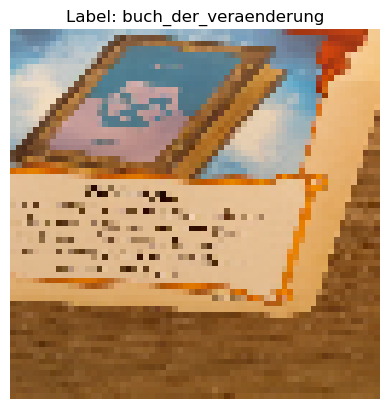

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
This image most likely belongs to buch_der_veraenderung with a 100.00 percent confidence.


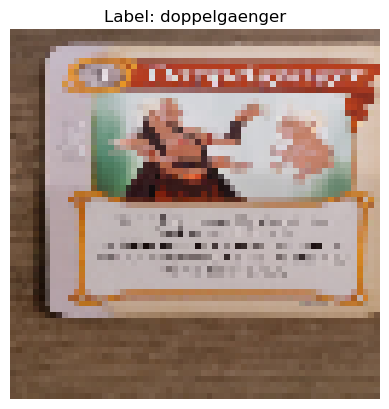

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
This image most likely belongs to doppelgaenger with a 100.00 percent confidence.


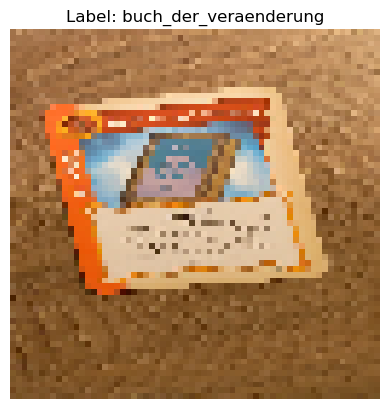

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
This image most likely belongs to buch_der_veraenderung with a 100.00 percent confidence.


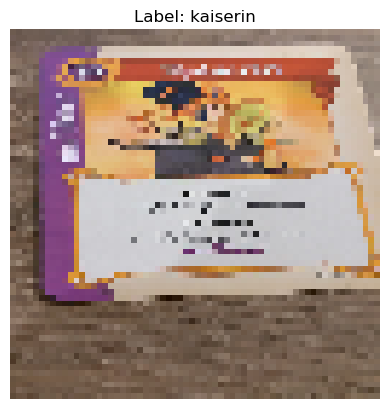

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
This image most likely belongs to kaiserin with a 100.00 percent confidence.


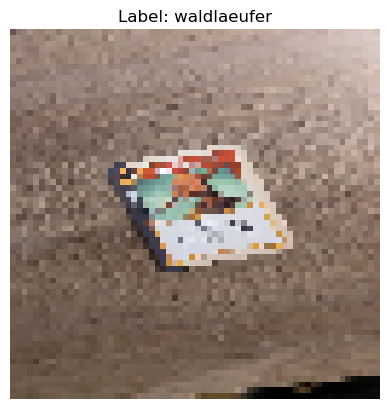

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
This image most likely belongs to waldlaeufer with a 100.00 percent confidence.


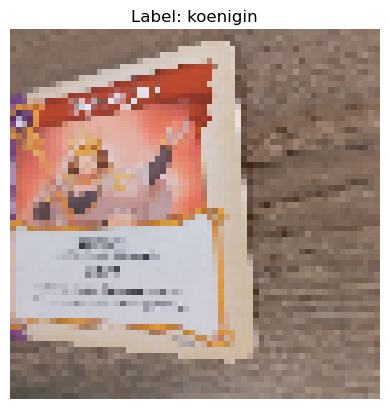

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
This image most likely belongs to koenigin with a 100.00 percent confidence.


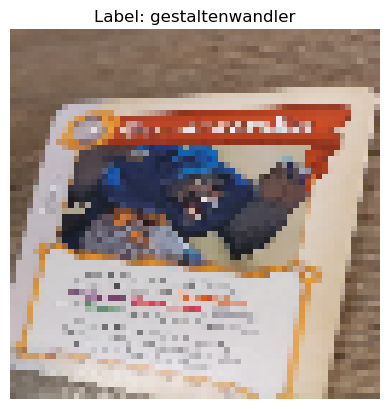

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
This image most likely belongs to gestaltenwandler with a 100.00 percent confidence.


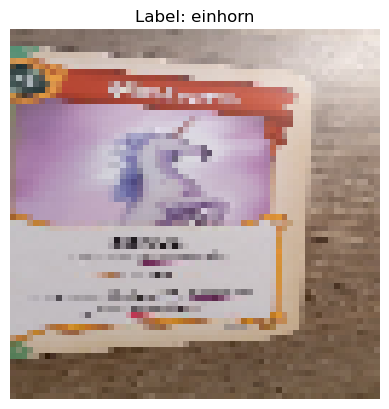

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
This image most likely belongs to einhorn with a 100.00 percent confidence.


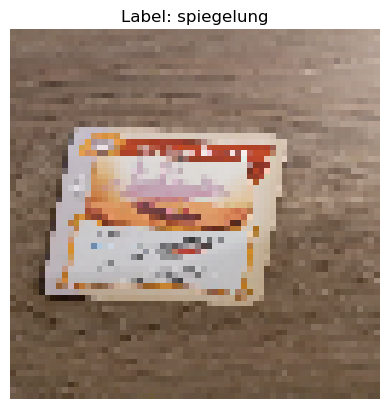

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
This image most likely belongs to spiegelung with a 100.00 percent confidence.


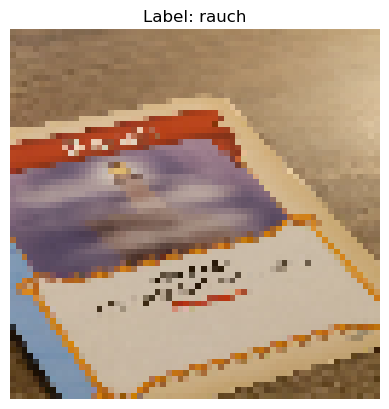

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
This image most likely belongs to rauch with a 100.00 percent confidence.


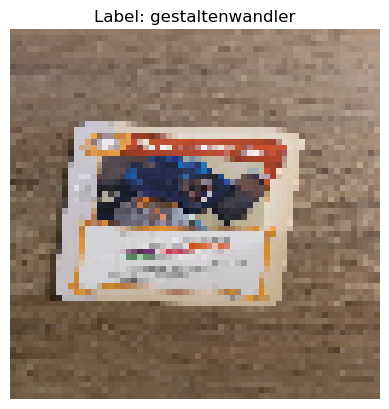

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
This image most likely belongs to gestaltenwandler with a 100.00 percent confidence.


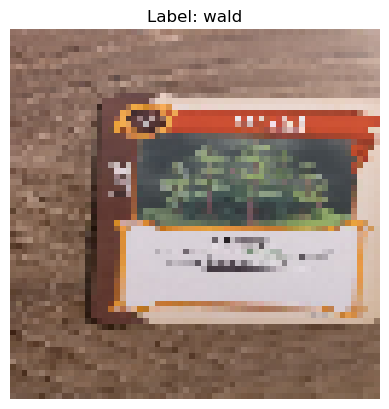

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
This image most likely belongs to wald with a 100.00 percent confidence.


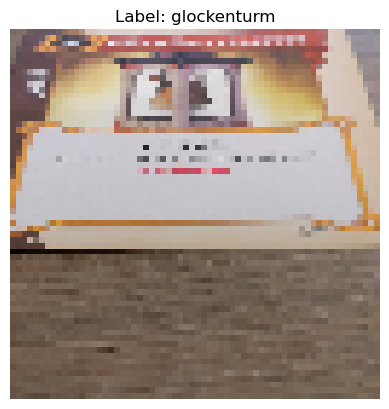

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
This image most likely belongs to glockenturm with a 99.96 percent confidence.


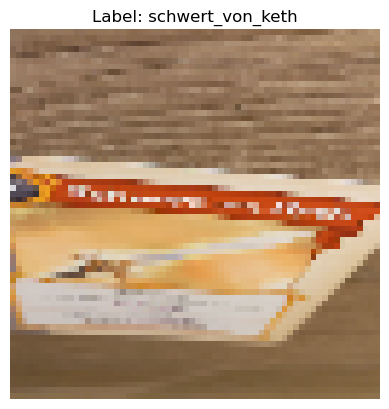

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
This image most likely belongs to schwert_von_keth with a 100.00 percent confidence.


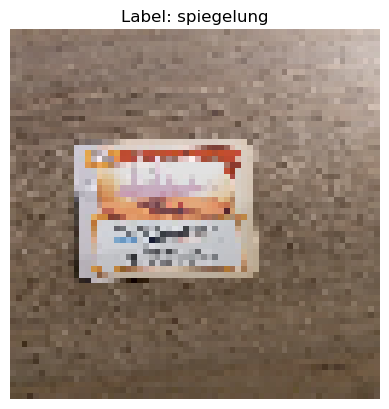

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
This image most likely belongs to spiegelung with a 100.00 percent confidence.


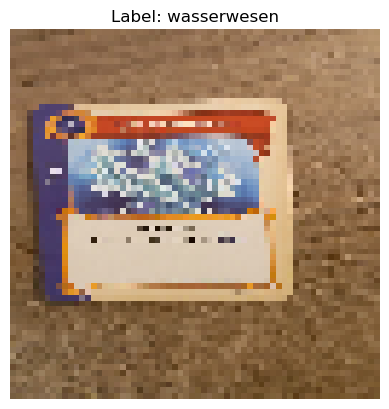

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
This image most likely belongs to wasserwesen with a 100.00 percent confidence.


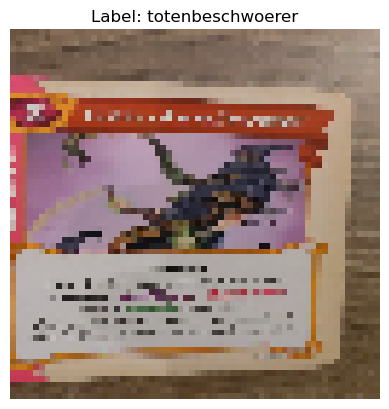

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
This image most likely belongs to totenbeschwoerer with a 100.00 percent confidence.


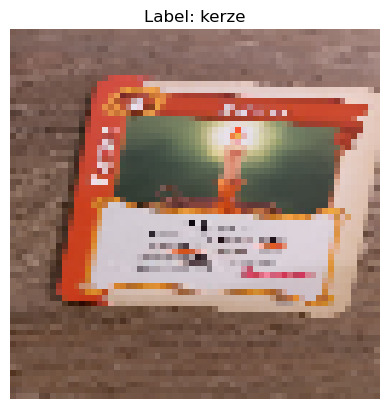

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
This image most likely belongs to kerze with a 100.00 percent confidence.


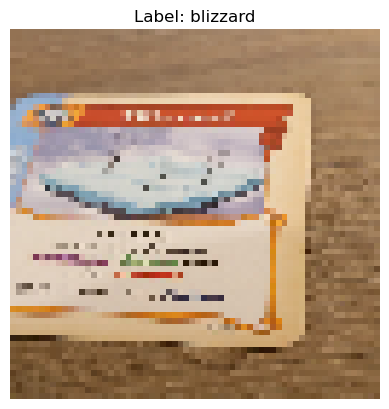

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
This image most likely belongs to blizzard with a 100.00 percent confidence.


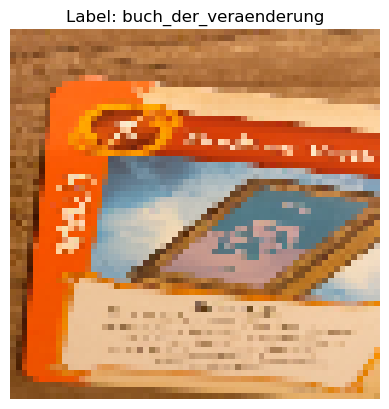

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
This image most likely belongs to buch_der_veraenderung with a 100.00 percent confidence.


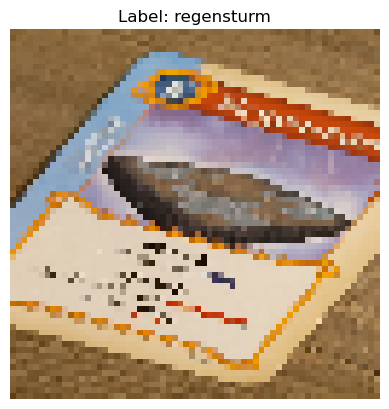

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
This image most likely belongs to regensturm with a 100.00 percent confidence.


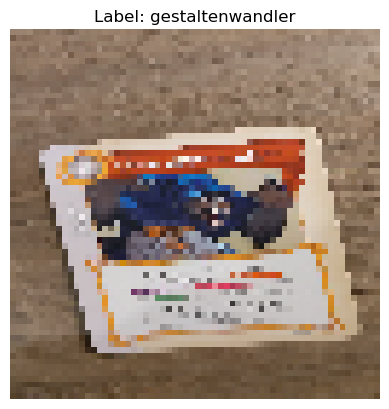

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
This image most likely belongs to gestaltenwandler with a 100.00 percent confidence.


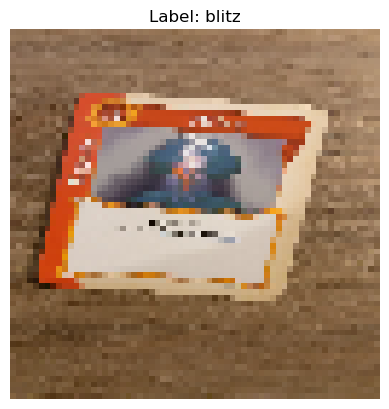

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
This image most likely belongs to blitz with a 100.00 percent confidence.


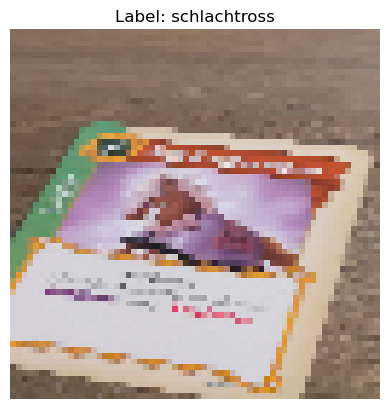

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
This image most likely belongs to schlachtross with a 100.00 percent confidence.


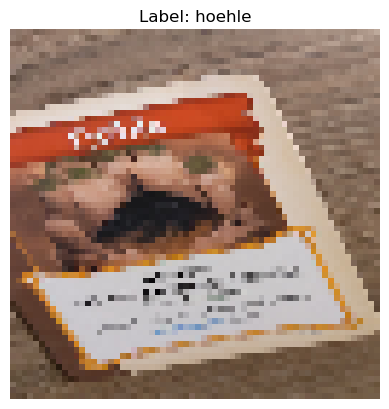

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
This image most likely belongs to hoehle with a 100.00 percent confidence.


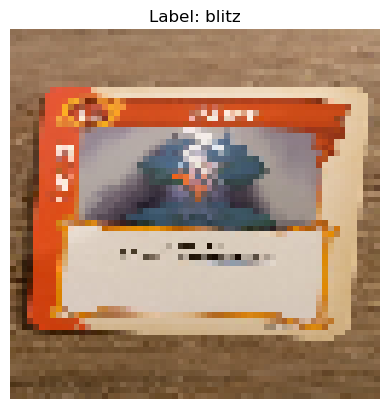

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
This image most likely belongs to blitz with a 100.00 percent confidence.


In [176]:
for input, label in val_ds.take(1): 
    images = input.numpy()

    for i in range(len(images)):
        plt.imshow(images[i].astype("uint8"))  
        plt.title(f"Label: {card_names_sep[label[i].numpy()]}") 
        plt.axis("off") 
        plt.show()
    
        img_array = tf.keras.utils.img_to_array(input[i])
        img_array = tf.expand_dims(img_array, 0)
        predictions = model.predict(img_array)
        score = tf.nn.softmax(predictions[0])

        pos = np.argmax(score)
        prediction = card_names_sep[pos]

        print(
            "This image most likely belongs to {} with a {:.2f} percent confidence."
            .format(prediction, 100 * np.max(score))
        )

In [ ]:
model.save("C:/Users/Test/Desktop/WiSe24/nn/project/model/model_small_50.keras")

## Confusion Matrix and Heatmap

In [ ]:
model = tf.keras.models.load_model("C:/Users/Test/Desktop/WiSe24/nn/project/model/model_small_50.keras")

We now want to analyze if there are certain cards that have a greater likelihood of being classified. For this we will create a so called confusion matrix. To get started we load the previously trained model, and fetch all (true) labels and the models prediction of the validation data.

In [ ]:
all_predictions = []
all_labels = []

for inputs, labels in val_ds:
    y_prediction = model.predict(inputs) 
    y_prediction = np.argmax(y_prediction, axis=1)
    all_predictions.extend(y_prediction)
    all_labels.extend(labels.numpy())

In [210]:
result = confusion_matrix(all_labels, all_predictions)
print(result)

[[ 92   0   0 ...   0   0   0]
 [  0  98   0 ...   0   0   0]
 [  0   0  92 ...   0   0   0]
 ...
 [  0   0   0 ...  94   0   0]
 [  0   0   0 ...   0 102   5]
 [  0   0   0 ...   0   0 105]]


Because 53x53 matrices are rarely nice to read, we create a heatmap to visualize our confusion matrix.

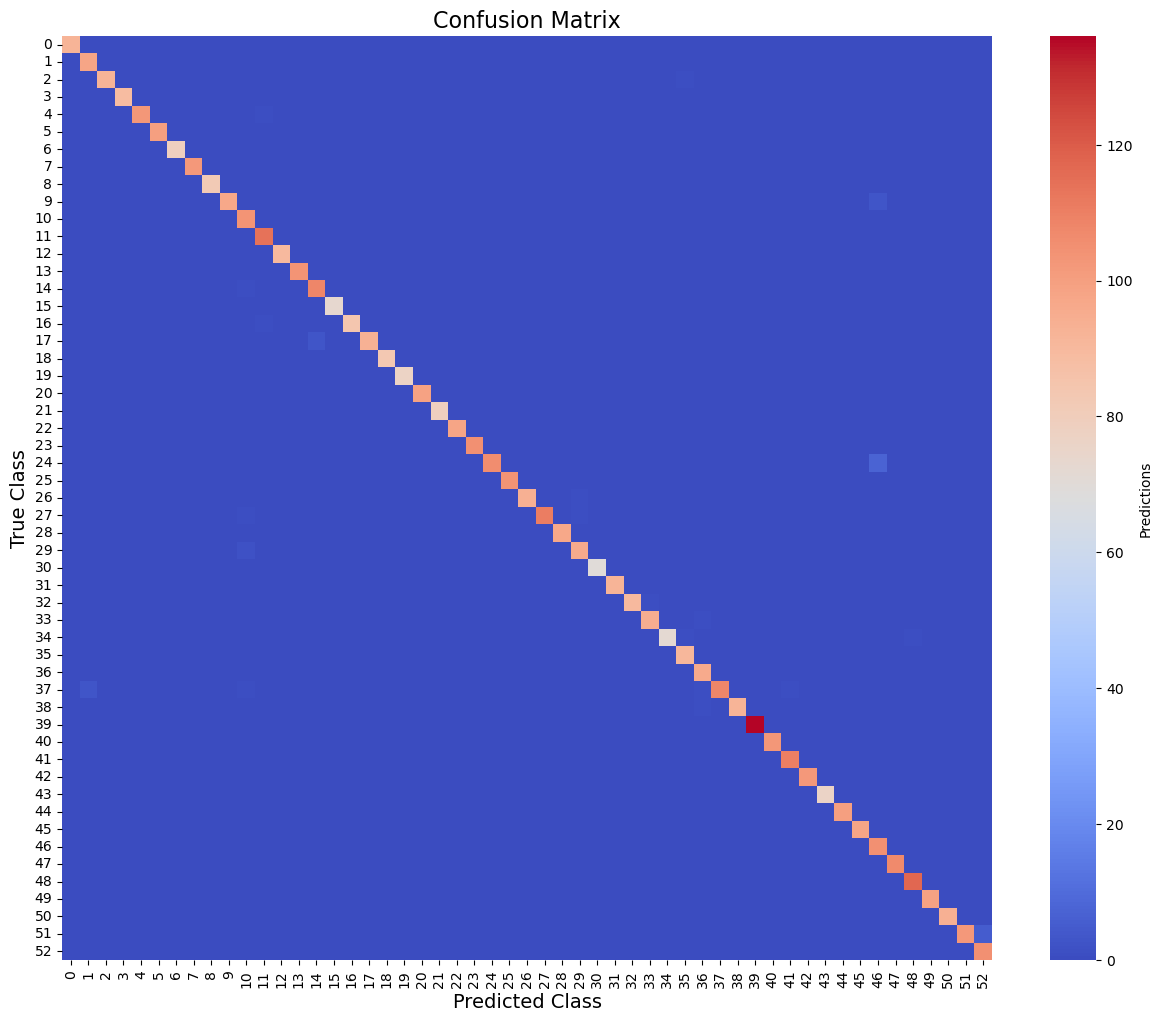

In [213]:
plt.figure(figsize=(15, 12))
sns.heatmap(result, fmt='.2f', cmap='coolwarm', cbar_kws={'label': 'Predictions'})
 
plt.title('Confusion Matrix', fontsize=16)
plt.xlabel('Predicted Class', fontsize=14)
plt.ylabel('True Class', fontsize=14)

plt.show()

We see an Outlier! Clearly card 39 gets predicted more often than all the others! Let's see which card we are dealing with.

In [216]:
x = card_names_sep[39]
print(x)

schild_von_keth


So "schild_von_keth" has a higher probability of being predicted than all other cards? Well ... no. I was just about to conclude exactly that, but got sceptical from my results. What does it really say? The heatmap shows that the TOTAL AMOUNT of prediction was highest for this card. I wrote a short script which counts the amount of images in the training data for each class, and sorted them by size. The results: \
39: 631 elements \
27: 573 elements\
37: 566 elements\
51: 546 elements\
... \
class 39 ("schild_von_keth") simply had the most training data, of course it would be predicted more often! We can fix this by normalizing the rows i.e. dividing the count in each row by the amount of elements in that class. Let's calculate the results again with normalization.

In [195]:
result = confusion_matrix(all_labels, all_predictions, normalize='true')
print(result)

[[1.         0.         0.         ... 0.         0.         0.        ]
 [0.         1.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.98924731 ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 1.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.95327103 0.04672897]
 [0.         0.         0.         ... 0.         0.         1.        ]]


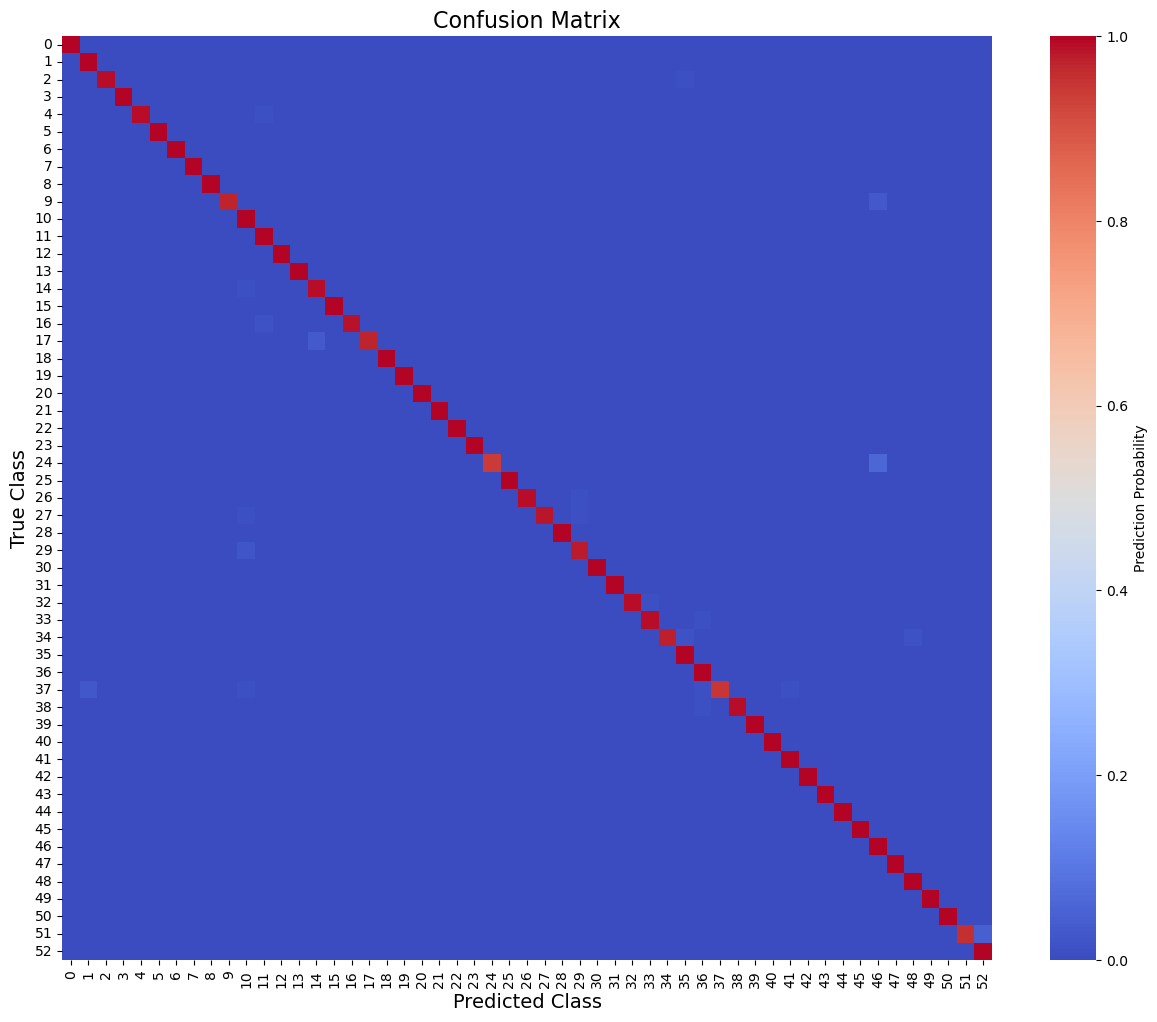

In [197]:
plt.figure(figsize=(15, 12))
sns.heatmap(result, fmt='.2f', cmap='coolwarm', cbar_kws={'label': 'Prediction Probability'})
 
plt.title('Confusion Matrix', fontsize=16)
plt.xlabel('Predicted Class', fontsize=14)
plt.ylabel('True Class', fontsize=14)

plt.show()

The heatmap overall looks pretty good! We can see some slight outliers, with (46,24) being the most significant. Let's see which cards these coordinates translate to:

In [201]:
x = card_names_sep[46]
y = card_names_sep[24]
print("(",x,',',y,")")

( wald , kerze )


This means "kerze" is often wrongly identified as "wald". Why? Both cards have exactly the same green-ish background. A very forgiveable error in my opinion. ;)

## Misc 


For use in Android Studio, i had to migrate the keras model to TFLite.

In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

with open('model_small_50.tflite', 'wb') as f:
    f.write(tflite_model)